In [26]:
# Standard library imports
import os
import sys
import re
import itertools
import glob
import pickle
import zipfile

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import mpmath
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from tqdm import tqdm
from scipy import stats, optimize as opt, signal
from scipy.special import hyp2f1
from matplotlib.colors import TwoSlopeNorm, LogNorm
from matplotlib.ticker import (
    ScalarFormatter, LogLocator, LogFormatterMathtext, LogFormatter,
    AutoMinorLocator, MultipleLocator, NullFormatter
)
from matplotlib.markers import MarkerStyle
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg

# Figure and plotting settings
fig_formats = ['.pdf', '.eps', '.tiff', '.png']
golden = (1 + 5 ** 0.5) / 2
cms = 0.393701
figsize = (golden * 8 * cms, 8 * cms)
figsizes = {
    "1 column": (3.43, 3.43 / golden),
    "1.5 columns": (4.49, 4.49 / golden),
    "2 columns": (7.01, 7.01 / golden)
}

# Color palettes
light_palette = ['#504B43', '#4caf50', '#948d99']
dark_palette = ['#285DB1', '#AC3127', '#c1bbb0']
color_clusters = ['#648fff', '#ffb000', '#948d99']
paletteTGB = ['#4caf50', '#504B43', '#948d99']
metaTcolor, metaGcolor, metaBcolor = paletteTGB
metacolor = {'metaT': metaTcolor, 'metaG': metaGcolor, 'metaB': metaBcolor}
metamarker = {'metaT': 'o', 'metaG': 'd', 'metaB': 's'}
palettename = 'coolwarm'
palette_temp = sns.color_palette(palettename, 32)

# Load world map data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Seaborn and matplotlib settings
sns.set_theme(
    rc={
        'figure.figsize': figsizes["2 columns"],
        'figure.dpi': 200,
        'savefig.dpi': 300
    },
    font="Helvetica Neue",
    font_scale=1.3,
    style="ticks"
)

plt.rcParams.update({
    'legend.edgecolor': 'k',
    'legend.facecolor': 'w',
    'legend.frameon': True,
    'legend.framealpha': 1,
    'legend.fancybox': False,
    'legend.fontsize': 12,
    'axes.linewidth': 1.5,
    'axes.edgecolor': 'k',
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'axes.labelsize': 14,
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "text.latex.preamble": r"\usepackage{amsmath, helvet} \renewcommand{\familydefault}{\sfdefault}"
})

# Jupyter autoreload magic
%reload_ext autoreload
%autoreload 1

In [27]:
def log_hist(data, nbins=30):    
    data_positive = data[data > 0]
    bins = np.logspace(np.log10(data_positive.min()), np.log10(data_positive.max()), nbins)
    counts = np.histogram(data_positive, bins=bins)[0]
    prob = counts / counts.sum()
    pdf = prob / np.diff(bins)
    return bins, counts, prob, pdf

def return_color_station(station, metadata, palette_temp=palette_temp):
    # if station is a string convert to integer
    if isinstance(station, str):
        station = int(station)
    temperature = int(metadata.loc[station, 'temp_woa'])+1
    return palette_temp[temperature]

def plot_logSAD(data, nbins=20):
    bins, counts, prob, pdf = log_hist(data, nbins=nbins)
    xx = np.sqrt(bins[:-1]*bins[1:])
    yy = pdf
    xx = xx[yy>0]
    yy = yy[yy>0]
    return xx, yy

def plot_logrescaledSAD(data, nbins=20):
    data = data[data>0]
    y = np.log(data)
    z = (y-np.mean(y))/np.std(y)
    hist, bins = np.histogram(z, bins=nbins, density=True)
    xx = (bins[1:] + bins[:-1])/2
    yy = hist
    xx = xx[yy>0]
    yy = yy[yy>0]
    return xx, yy

In [29]:
metadata = pd.read_csv('../data/environment/woa_pisces_tarassd.tsv', index_col=0, sep='\t')
metadata.index = metadata.index.astype(int)
metadata = gpd.GeoDataFrame(metadata, geometry=gpd.points_from_xy(metadata.longitude, metadata.latitude), crs="ESRI:54030")

metadata['temp_category'] = pd.cut(metadata.temp_woa, bins=[-np.inf, 15, np.inf], labels=['low', 'high'])
metadata['inverseTemperature'] = 1000/(metadata['temp_woa']+273.15)

In [31]:
zipfile_path = '../data/filter/metaGT_micro_bacilla.zip'
if not os.path.exists(zipfile_path):
    raise FileNotFoundError(f"Zip file not found: {zipfile_path}")
with zipfile.ZipFile(zipfile_path, 'r') as z:
    z.extractall('../data/')

In [32]:
# columns are integers
metaT = pd.read_csv(f'../data/metaT_micro_bacilla.csv', index_col=0)
metaG = pd.read_csv(f'../data/metaG_micro_bacilla.csv', index_col=0)
metaT.columns = metaT.columns.astype(int)
metaG.columns = metaG.columns.astype(int)
# /Users/epigani/Library/CloudStorage/GoogleDrive-emanuele.pigani.1@unipd.it/.shortcut-targets-by-id/17Sn-Ra2REh5B86l96gE_Smchh22WCsgo/PhD-Emanuele Pigani/finished_projects/Pigani HayMele et al 2024/downscaling_richness/data/Abundance.csv
#metaB = pd.read_csv(f'{directory}/metaB_micro/Abundances_C.csv', index_col=0)

df_meta = {'metaT': metaT, 'metaG': metaG}
df_meta_relative = {key: df.div(df.sum(axis=0), axis=1) for key, df in df_meta.items()}

del metaT, metaG


In [33]:
gdf = metadata.copy()
gdf['mean_metaT'] = df_meta['metaT'].sum(axis=0)/df_meta['metaT'].astype(bool).sum(axis=0)
gdf['mean_metaG'] = df_meta['metaG'].sum(axis=0)/df_meta['metaG'].astype(bool).sum(axis=0)
gdf['total_metaT'] = df_meta['metaT'].sum(axis=0)
gdf['total_metaG'] = df_meta['metaG'].sum(axis=0)

In [34]:
def mercator_lon_to_x(lon):
    """Converte longitudine (in gradi) in X Mercator (in metri)."""
    R = 6378137  # Raggio terrestre (m)
    return R * np.radians(lon)

def lon_to_axes_x(lon, ax):
    """Converte una longitudine in coordinate 'axes' (da 0 a 1) secondo xlim in Mercator."""
    x0, x1 = ax.get_xlim()  # in metri
    x = mercator_lon_to_x(lon)
    return (x - x0) / (x1 - x0)

def mercator_lat_to_y(lat):
    """Converte una latitudine (in gradi) in coordinata Y Mercator (in metri)."""
    R = 6378137  # Raggio terrestre (m)
    lat_rad = np.radians(lat)
    return R * np.log(np.tan(np.pi / 4 + lat_rad / 2))

def lat_to_axes_y(lat, ax):
    """Converte una latitudine in coordinate 'axes' (da 0 a 1) secondo ylim in Mercator."""
    y0, y1 = ax.get_ylim()  # in metri, Mercator
    y = mercator_lat_to_y(lat)
    return (y - y0) / (y1 - y0)

In [35]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.ticker import FixedLocator

/var/folders/c6/wyfkjjbx7951r06nx266f2z80000gn/T/ipykernel_59173/832920721.py:116: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = plt.Rectangle((0.74, 0.05), 0.245, 0.6, transform=ax.transAxes, zorder=10, color='white', alpha=0.75, edgecolor='k', lw=0.5)


Axis dimensions in inches: 4.776611870091256 x 3.24931369
Figure dimensions in inches: 5.25749999053034 x 3.24931369


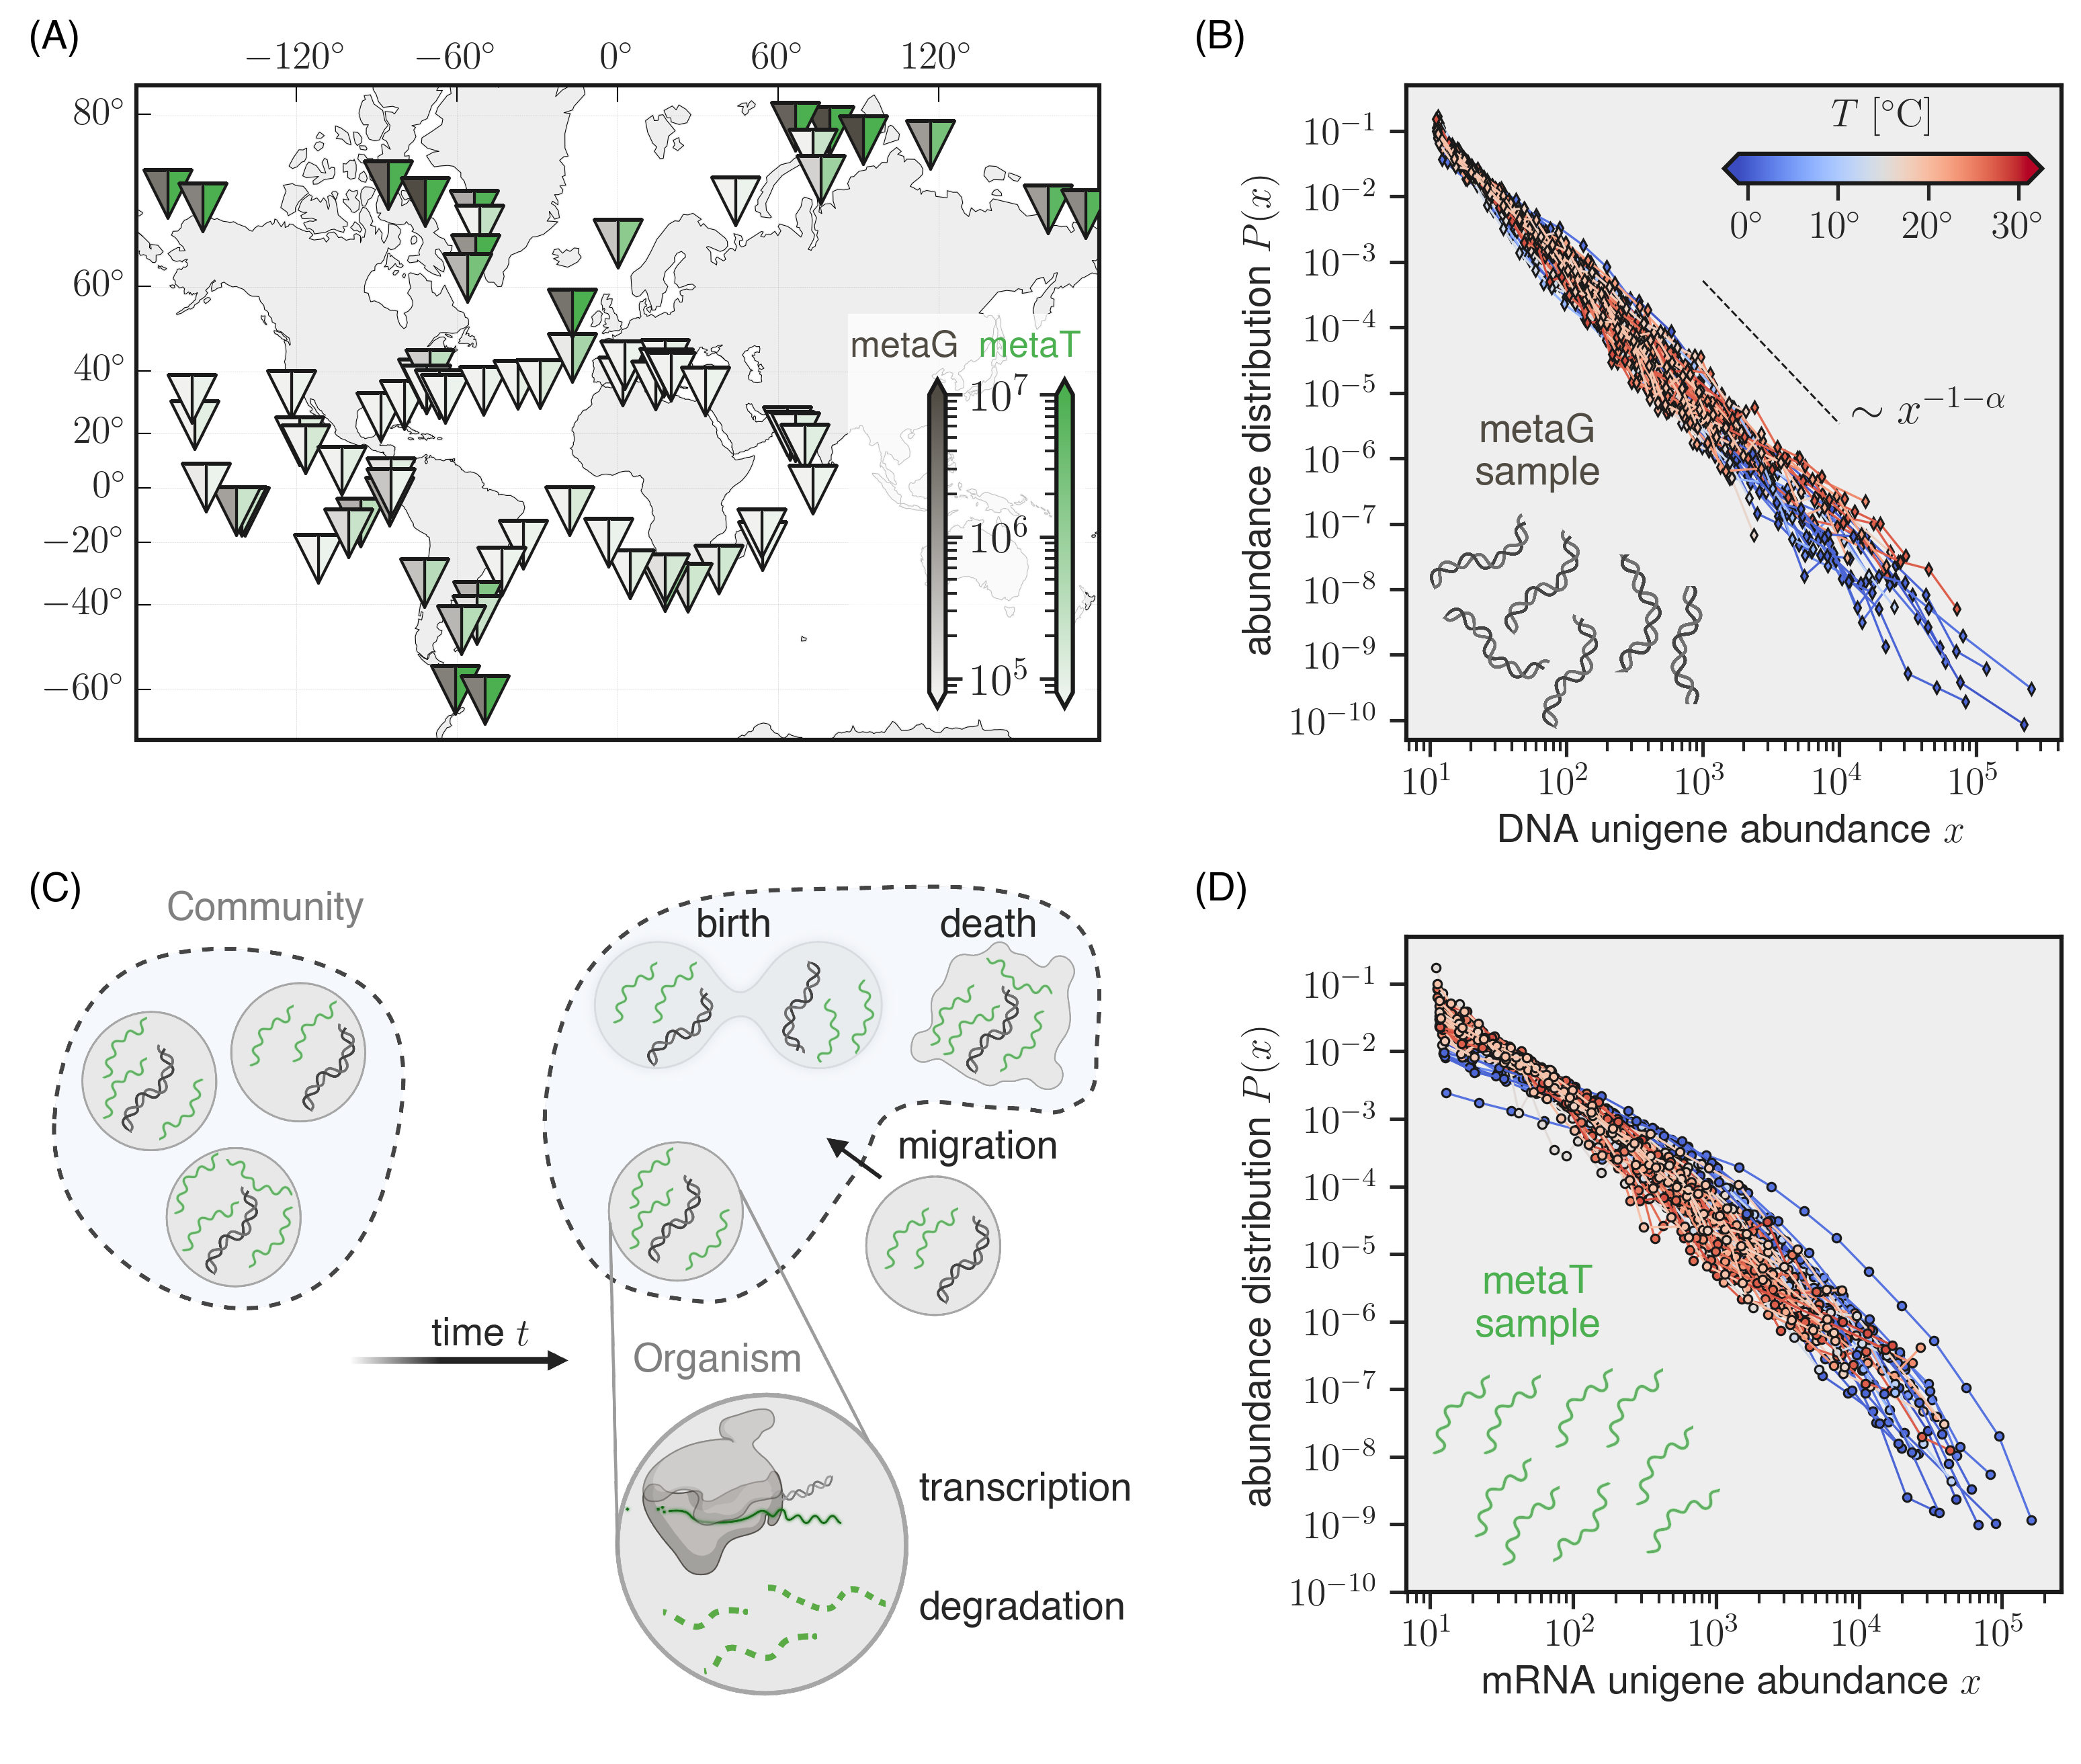

In [36]:
height = 3.24931369
phi = (1 + 5**0.5) / 2  # Golden ratio

projection = ccrs.Mercator()
#fig, ax = plt.subplots(1, figsize=(height*phi*2, height*2), constrained_layout=False, sharey=False, subplot_kw={'projection': projection})

fig = plt.figure(figsize=(height*phi, height), dpi=300)
ax = fig.add_axes([0., 0., phi, 1], projection=projection)
fontsize = 14

cmaps = [sns.light_palette("#4caf50", reverse=False, as_cmap=True), sns.light_palette('#FF6900', reverse=False, as_cmap=True)]
cmaps = [sns.light_palette("#F6A97A", reverse=False, as_cmap=True), sns.light_palette("#4B2991", reverse=False, as_cmap=True)][::-1]
cmaps = [sns.light_palette("#504B43", reverse=False, as_cmap=True), sns.light_palette('#4caf50', reverse=False, as_cmap=True)][::-1]

ax.set_global()
ax.set_ylim(-10496570.739723718, 16764656.23138056)
ax.coastlines(linewidth=0.25)
#ax.add_feature(cfeature.OCEAN, color='lightblue')
ax.add_feature(cfeature.LAND, color='#EEEEEE') 

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.15, color='gray', alpha=0.35, linestyle='--', zorder=0)
xloc = [-120, -60, 0, 60, 120]
gl.xlocator = FixedLocator(xloc)
yloc = [-60, -40, -20, 0, 20, 40, 60, 80]
gl.ylocator = FixedLocator(yloc)


for lon in xloc:
    text = r"${}^\circ$".format(lon)
    lon_ax = lon_to_axes_x(lon, ax)   
    lat_ax = 1.0
    delta_y = 0.025#/phi 
    ax.text(lon_ax, lat_ax+delta_y/2,  text, transform=ax.transAxes, fontsize=fontsize, ha='center', va='bottom', usetex=True)
    ax.plot([lon_ax, lon_ax],[lat_ax - delta_y, lat_ax + delta_y], transform=ax.transAxes,color='black',linewidth=0.5,)

for lat in yloc:
    text = r"${}^\circ$".format(lat)   
    lon_ax = -0.01
    lat_ax = lat_to_axes_y(lat, ax)
    delta_x = 0.025
    ax.text(lon_ax, lat_to_axes_y(lat, ax), text, transform=ax.transAxes, fontsize=fontsize, ha='right', va='center', usetex=True)
    #ax.text(tick_x, lat, text, transform=ccrs.PlateCarree(), fontsize=10, ha='right', va='center', usetex=True)
    ax.plot([lon_ax - delta_x, lon_ax + delta_x],[lat_ax, lat_ax], transform=ax.transAxes,color='black',linewidth=0.5,)         


# Rimuove etichette in alto e destra
gl.top_labels = False
gl.right_labels = False

vmin, vmax = 0.8e5, 1e7

# slow but good 
slow = True
if slow == True:
        for index in gdf.index[-0:]:
                try:
                        column = 'total_metaT'
                        cmap = cmaps[0]
                        df = gdf[gdf.index == index]
                        df.plot(column=column, transform=ccrs.Geodetic(), ax=ax, lw=1, marker=MarkerStyle("v", fillstyle="right"), cmap=cmap,
                                edgecolor='k', markersize=300, zorder=10, norm=LogNorm(vmin=vmin, vmax=vmax), legend=False)

                        column = 'total_metaG'
                        cmap = cmaps[1]
                        df.plot(column=column, transform=ccrs.Geodetic(), ax=ax, lw=1, marker=MarkerStyle("v", fillstyle="left"), cmap=cmap,
                                edgecolor='k', markersize=300, zorder=10, norm=LogNorm(vmin=vmin, vmax=vmax), legend=False)
                except:
                        pass

# Plot and add legends separately for 'total_metaT'
column = 'total_metaT'
alpha_slow = {True: 0., False: 1.}
gdf.plot(column=column, transform=ccrs.Geodetic(), ax=ax, lw=1, marker=MarkerStyle("v", fillstyle="right"), cmap=cmaps[0],
         edgecolor='k', markersize=300, zorder=10, norm=LogNorm(vmin=vmin, vmax=vmax), alpha=alpha_slow[slow], legend=True,
         legend_kwds={'shrink': 0.5, 'pad': 0.1, 'orientation': 'vertical', 'extend': 'both', "fmt": "{:1.0e}",
                    #  'bbox_to_anchor': (1.05, 0.5), 'loc': 'center left'
                      })

# Retrieve the colorbar
cbar = ax.get_figure().get_axes()[-1]
cbar.tick_params(labelsize=12)
cbar.set_position([0.87, 0.05, 0.35, 0.5])   # Adjust position for the first legend
cbar.yaxis.set_minor_locator(plt.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=10))
# Customize grid
cbar.yaxis.set_major_locator(LogLocator(base=10.0, numticks=10))
cbar.yaxis.set_major_formatter(LogFormatterMathtext())
cbar.yaxis.tick_left()
# remove labels
cbar.yaxis.set_tick_params(labelleft=False)
# set background color
cbar.set_facecolor('white')
# set transparency of background color

# Plot and add legends separately for 'total_metaG'
column = 'total_metaG'
gdf.plot(column=column, transform=ccrs.Geodetic(), ax=ax, lw=1, marker=MarkerStyle("v", fillstyle="left"), cmap=cmaps[1],
         edgecolor='k', markersize=300, zorder=10, norm=LogNorm(vmin=vmin, vmax=vmax), alpha=alpha_slow[slow], legend=True,
         legend_kwds={'shrink': 0.5, 'pad': 0.1, 'orientation': 'vertical', 'extend': 'both', "fmt": "{:1.0e}"})

# Retrieve the second colorbar
cbar2 = ax.get_figure().get_axes()[-1]
cbar2.tick_params(labelsize=16)
cbar2.set_position([0.75, 0.05, 0.35, 0.5])   # Adjust position for the second legend
cbar2.yaxis.set_minor_locator(plt.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=10))
# Customize grid
cbar2.yaxis.set_major_locator(LogLocator(base=10.0, numticks=10))
cbar2.yaxis.set_major_formatter(LogFormatterMathtext())
# set yticks and labels to the left

# draw a white rectangle to ax
rectangles = True
if rectangles:
        rect = plt.Rectangle((0.8, 0.05), 0.18, 0.52, transform=ax.transAxes, zorder=10, color='white', alpha=0.5)
        #ax.add_patch(rect)
        
        rect = plt.Rectangle((0.74, 0.05), 0.245, 0.6, transform=ax.transAxes, zorder=10, color='white', alpha=0.75, edgecolor='k', lw=0.5)
        ax.add_patch(rect)

        # rect = plt.Rectangle((0.82, 0.57), 0.17, 0.08, transform=ax.transAxes, zorder=10, color='white')
        # ax.add_patch(rect)

text = 'metaG'
ax.text(0.8, 0.6, text, transform=ax.transAxes, ha='center', va='center', fontsize=fontsize-1, color=metacolor['metaG'],
        bbox=dict(facecolor='none', edgecolor='none', pad=3.0),zorder=11)
text = 'metaT'
ax.text(0.93, 0.6, text, transform=ax.transAxes, ha='center', va='center', fontsize=fontsize-1, color=metacolor['metaT'],
        bbox=dict(facecolor='none', edgecolor='none', pad=3.0),zorder=11)

bbox = ax.get_position()         # In figure-relative coordinates (0–1)
fig_width, fig_height = fig.get_size_inches()  # Size of figure in inches
ax_width = bbox.width * fig_width
ax_height = bbox.height * fig_height

print(f"Axis dimensions in inches: {ax_width} x {ax_height}")
print(f"Figure dimensions in inches: {fig_width} x {fig_height}")
        
        
# Create a new axis ax2
ax2 = fig.add_axes([1.2, 0., 1/phi, 1])

# Set log scale and labels for ax2
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel(r"DNA unigene abundance $x$")
ax2.set_ylabel(r"abundance distribution  $P(x)$")
ax2.set_ylim(5e-11, 5e-1)
ax2.xaxis.set_major_locator(LogLocator(base=10.0, numticks=10))
ax2.xaxis.set_major_formatter(LogFormatterMathtext())
ax2.xaxis.set_minor_locator(plt.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=10))
ax2.yaxis.set_major_locator(LogLocator(base=10.0, numticks=10))
ax2.yaxis.set_major_formatter(LogFormatterMathtext())
ax2.yaxis.set_minor_locator(plt.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=10))
ax2.set_yticks([1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
zoom= 0.035
img = mpimg.imread('../figures/sketches/sketchG.png')
imagebox2 = OffsetImage(img, zoom=zoom)
ab2 = AnnotationBbox(imagebox2, (1e2, 1e-8), frameon=False)  # position in data coords
ax2.add_artist(ab2)

cax = fig.add_axes([1.5, 0.85, 0.3, 0.045])  # Adjust position and size for horizontal orientation
sm = plt.cm.ScalarMappable(cmap=palettename, norm=plt.Normalize(vmin=-1, vmax=31))
sm._A = []
cbar = fig.colorbar(sm, cax=cax, ticks=[0., 10., 20., 30.], orientation='horizontal', extend='both')
cbar.ax.set_xticklabels([r'$0^\circ$', r'$10^\circ$', r'$20^\circ$', r'$30^\circ$'], fontsize=fontsize, usetex=True)
cbar.ax.set_title(r'$T\ [^\circ\mathrm{C}]$', fontsize=fontsize, usetex=True, pad=10)

# Plot data for ax2
df = df_meta['metaG']
slopes = []
for station in df.columns[::-1]:
        data = df[station]
        x, y = plot_logSAD(data, nbins=20)
        log10x = np.log10(x)
        log10y = np.log10(y)
        # Fit a line to the data
        slope, intercept, r_value, p_value, std_err = stats.linregress(log10x, log10y)
        slopes.append(slope)
        color = return_color_station(station, metadata, palette_temp=palette_temp)
        sns.lineplot(x=x, y=y, ax=ax2, color=color, lw=0.8, marker=metamarker['metaG'], markersize=3, markeredgecolor='k') 

# Add a reference line to ax2
xmin = 10.
alpha = -np.mean(slopes)-1
x = np.logspace(3, 4., 100)
y = 100*alpha*xmin**(alpha)*x**(-alpha-1)
sns.lineplot(x=x, y=y, ax=ax2, color='k', lw=.7, ls='--', zorder=10)
text = r'$\sim x^{-1-\alpha}$'
ax2.text(0.8, 0.5, text, transform=ax2.transAxes, ha='center', va='center', fontsize=fontsize+2)

# Add text to ax2
text = "metaG"
#ax2.text(0.95, 0.95, text, transform=ax2.transAxes, ha='right', va='top', fontsize=fontsize+2, color=metacolor['metaG'], usetex=False)
ax2.text(0.2, 0.5, "metaG\nsample", transform=ax2.transAxes, ha='center', va='top', fontsize=fontsize, color=metacolor['metaG'], usetex=False)
ax2.set_facecolor("#EEEEEE")     

ax3 = fig.add_axes([1.2, -1.3, 1/phi, 1])

# Set log scale and labels for ax3
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel(r"mRNA unigene abundance $x$")
ax3.set_ylabel(r"abundance distribution  $P(x)$")
ax3.set_ylim(5e-10, 5e-1)
ax3.xaxis.set_major_locator(LogLocator(base=10.0, numticks=10))
ax3.xaxis.set_major_formatter(LogFormatterMathtext())
ax3.xaxis.set_minor_locator(plt.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=10))
ax3.yaxis.set_major_locator(LogLocator(base=10.0, numticks=10))
ax3.yaxis.set_major_formatter(LogFormatterMathtext())
ax3.yaxis.set_minor_locator(plt.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=10))
ax3.set_yticks([1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
zoom= 0.035
img = mpimg.imread('../figures/sketches/sketchT.png')
imagebox2 = OffsetImage(img, zoom=zoom)
ab2 = AnnotationBbox(imagebox2, (1e2, 3e-8), frameon=False)  # position in data coords
ax3.add_artist(ab2)

# Plot data for ax3
df = df_meta['metaT']
slopes = []
for station in df.columns[::-1]:
        data = df[station]
        x, y = plot_logSAD(data, nbins=20)
        color = return_color_station(station, metadata, palette_temp=palette_temp)
        sns.lineplot(x=x, y=y, ax=ax3, color=color, lw=0.8, marker=metamarker['metaT'], markersize=3, markeredgecolor='k') 


# Add text to ax3
text = "metaT"
#ax3.text(0.95, 0.95, text, transform=ax3.transAxes, ha='right', va='top', fontsize=fontsize+2, color=metacolor['metaT'], usetex=False)
ax3.text(0.2, 0.5, "metaT\nsample", transform=ax3.transAxes, ha='center', va='top', fontsize=fontsize, color=metacolor['metaT'], usetex=False)

ax3.set_facecolor("#EEEEEE")    

# add (A), (B), (C) to the top left corner of the figure
fig.text(-0.1, 1.1, '(A)', ha='left', va='top', fontsize=14, color='black', usetex=False)
fig.text(1., 1.1, '(B)', ha='left', va='top', fontsize=14, color='black', usetex=False)
fig.text(-0.1, -0.2, '(C)', ha='left', va='top', fontsize=14, color='black', usetex=False)
fig.text(1.,-0.2, '(D)', ha='left', va='top', fontsize=14, color='black', usetex=False)

ax4 = fig.add_axes([0, -1.3, 1, 1.3], frameon=False)
ax4.set_facecolor('none')
ax4.set_xticks([])
ax4.set_yticks([])
zoom= 0.13
img = mpimg.imread('../figures/sketches/sketch.png')
imagebox = OffsetImage(img, zoom=zoom)
ab = AnnotationBbox(imagebox, (0.42, 0.35), frameon=False)  # position in data coords
ax4.add_artist(ab)

ax4.text(0.03, 0.78, 'Community', transform=ax4.transAxes, fontsize=fontsize, verticalalignment='bottom', horizontalalignment='left', usetex=False, color='grey')
ax4.text(0.47, 0.25, 'Organism', transform=ax4.transAxes, fontsize=fontsize, verticalalignment='bottom', horizontalalignment='left', usetex=False, color='grey')
ax4.text(0.28, 0.28, 'time $t$', transform=ax4.transAxes, fontsize=fontsize, verticalalignment='bottom', horizontalalignment='left', usetex=True)
ax4.text(0.53, 0.76, 'birth', transform=ax4.transAxes, fontsize=fontsize, verticalalignment='bottom', horizontalalignment='left', usetex=False)
ax4.text(0.76, 0.76, 'death', transform=ax4.transAxes, fontsize=fontsize, verticalalignment='bottom', horizontalalignment='left', usetex=False)
ax4.text(0.72, 0.5, 'migration', transform=ax4.transAxes, fontsize=fontsize, verticalalignment='bottom', horizontalalignment='left', usetex=False)
ax4.text(0.74, 0.12, 'transcription', transform=ax4.transAxes, fontsize=fontsize, verticalalignment='center', horizontalalignment='left', usetex=False)
ax4.text(0.74, -0.02, 'degradation', transform=ax4.transAxes, fontsize=fontsize, verticalalignment='center', horizontalalignment='left', usetex=False)

figname = '../figures/fig1'
plt.savefig(f'{figname}.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()
